### Joshua Koonce
# AllLife Bank Customer Segmentation
## Clustering and PCA Project


The objective of this project is to identify segments of customers based on spending patterns and past interactions so that the bank can better target customers with promotions and programs. 

I will use clustering techniques to find patterns in the underlying data and then make recommendations to the bank on how to better approach these customers.

- Sl_No: Primary key of the records (will be unused)
- Customer Key: Customer identification number (will be unused)
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

Import staple data science libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('white')

# Data Pre-Processing and Cleaning

Load the dataset from source file into a Pandas DataFrame object

In [2]:
cccd = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
cccd.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
cccd.shape

(660, 7)

660 rows and 7 columns, but it looks like a couple columns won't be useful to the analysis.

Look at the data types for all columns

In [5]:
pd.DataFrame([cccd.dtypes, cccd.count()], index=['type', 'count']).T

,type,count
Sl_No,int64,660
Customer Key,int64,660
Avg_Credit_Limit,int64,660
Total_Credit_Cards,int64,660
Total_visits_bank,int64,660
Total_visits_online,int64,660
Total_calls_made,int64,660


Data types are fine and there's no true missing values, but I will still need to check for duplicates.

In [6]:
dupes = cccd[cccd['Customer Key'].duplicated()]
dupes

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,333,47437,17000,7,3,1,0
398,399,96929,67000,6,2,2,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


There appears to be five customer key's that are duplicated. They'll need to be handled.

In [7]:
cccd.drop_duplicates(subset=['Customer Key'], inplace=True)

Drop the two columns that aren't helpful to the analysis.

In [8]:
cccd.drop(['Sl_No', 'Customer Key'], inplace=True, axis=1)

In [9]:
cccd.shape

(655, 5)

So we're left with 655 rows and 5 columns of data.

# Exploratory Data Analysis and Data Preprocessing

In [10]:
cccd.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,655.000000,655.000000,655.000000,655.000000,655.000000
mean,34242.748092,4.691603,2.401527,2.606107,3.601527
std,37240.896986,2.169325,1.633648,2.940380,2.867352
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


A considerably cleaner dataset with no strange values for min, max, etc.

### Univariate Distributions EDA

Let's get the distributions of each numeric variable. Many are discrete.

In [11]:
## Define a function to plot all variables distributions, and if possible, a boxplot to show outliers and skew

def plot_uv(df, column):
    print('\tUnivariate Analysis: ', col)
    
    if df[column].dtypes.name != 'category':
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        # assigning a graph to each axis
        sns.boxplot(x=df[column], ax=ax_box)
        sns.histplot(data=df, x=column, ax=ax_hist)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel='')
        plt.show()
    else:
        sns.histplot(data=df, x=column)
        plt.show()

	Univariate Analysis:  Avg_Credit_Limit


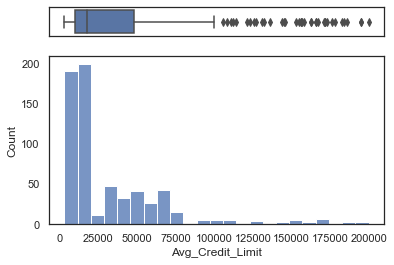

	Univariate Analysis:  Total_Credit_Cards


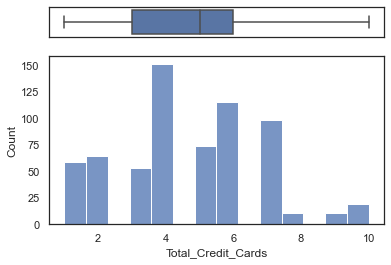

	Univariate Analysis:  Total_visits_bank


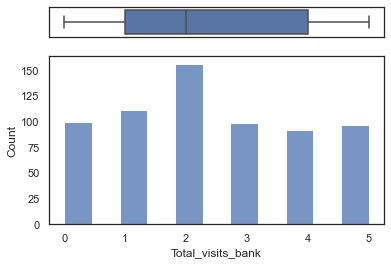

	Univariate Analysis:  Total_visits_online


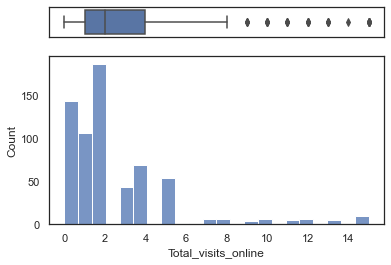

	Univariate Analysis:  Total_calls_made


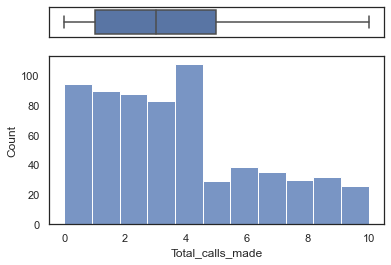

In [12]:
for col in cccd.columns:
        plot_uv(cccd, col)

Overall, no unexpected data.

- Average Credit Limit has a distribution similar to your standard median income distribution, which makes sense. The many outliers are normal.
- Average Credit Cards is somewhat normally distributed but not completely. It seems most customers have between 4-7 credit cards.
- Total Bank Visits is fairly uniform but has a peak at 2
- Total Visits online is initially very high but tapers off quickly, although some customers (like myself) seem to check their account frequently because of the convenience of doing so online
- Total calls made peaks at 4 then significantly decreases at 5 and beyond, perhaps indicating a once-weekly preference for telephone comms

### Bi-variate EDA

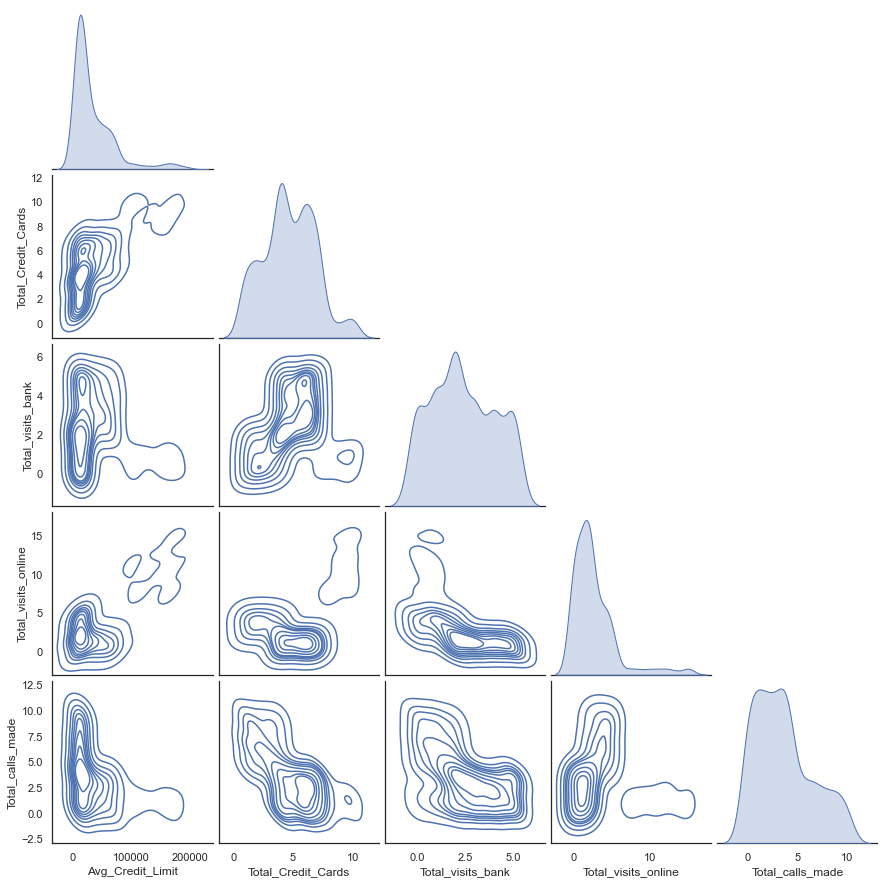

In [13]:
sns.pairplot(cccd, corner=True, kind='kde', diag_kind='kde');

The KDE display of the scatterplots indicates that there are some likely clusters that can be distinguished here. Some observations are completely separate from the pack, and some packs seem multimodal.

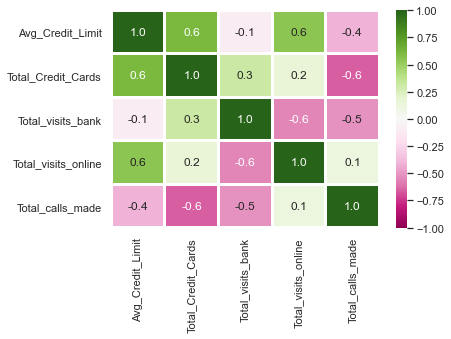

In [14]:
sns.heatmap(cccd.corr(), vmin=-1, vmax=1, linewidths=2, annot=True, fmt='.1f', cmap='PiYG');

A heatmap to show the correlation amongst variables. Some variables are pretty strongly correlated, both negatively and positively. Interesting takeaways:
- Total_calls_made is negatively correlated with Credit Limit and Credit Cards
- Total_visit_online seems to correlate highly positively to Average Credit Limit and Total Credit Cards
- Total_Credit_Cards increases strongly with Avg_Credit_Limit (makes sense)
- Customers tend to prefer one method of interacting with the bank digitally based on their credit limits and situation

## Data Standardization

The data must be standardized to be fed into unsupervised algorithms.

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

The standard scaler will reduce each variable to a ratio from its mean, which will drastically reduce the impact the difference in size between variablesh as in influencing the clustering algorithms.

In [17]:
cccd_s = pd.DataFrame(scaler.fit_transform(cccd))

In [18]:
cccd_s.columns = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']

In [19]:
cccd_s.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.767076,-1.241704,-0.858568,-0.546642,-1.257006
1,0.423440,-0.780379,-1.471163,2.516526,1.884177
2,0.423440,1.064922,-0.858568,0.134062,0.139075
3,-0.114014,0.142271,-0.858568,-0.546642,0.139075
4,1.767076,0.603597,-1.471163,3.197230,-0.209945


The scaled data. You can now see each variable has a mean of near 0 and a standard deviation of 1.

## KMeans Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

Determine the optimal amount of clusters

In [21]:
results = []
sil_scores = []

# since KMeans is cheap, computationally, we can find the best number of clusters by spamming:
for k in range(2,11):
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(cccd_s)
    results.append(km.inertia_)
    sil_scores.append(silhouette_score(cccd_s, labels))


Elbow plot to help identify the optimal amount of clusters:

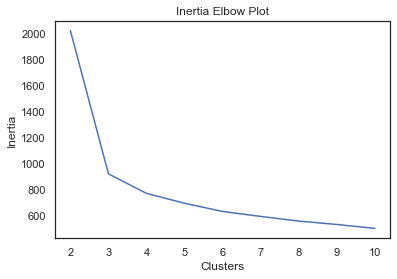

In [22]:
plt.plot(range(2,11), results)
plt.title('Inertia Elbow Plot')
plt.ylabel('Inertia')
plt.xlabel('Clusters')
plt.show();

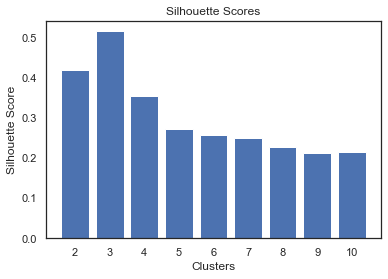

In [23]:
plt.bar(range(2,11), sil_scores)
plt.title('Silhouette Scores')
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters')
plt.xticks(ticks=range(2,11))
plt.show();

Both assessment methods suggest 3 clusters are appropriate.

Running the model with the optimal clusters.

In [24]:
# reinitialize the variable
km = KMeans(n_clusters=3)

# fit the data and feed predictions into the dataframe
cccd_s['km_class'] = km.fit_predict(cccd_s)

In [25]:
cccd_s.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,km_class
0,1.767076,-1.241704,-0.858568,-0.546642,-1.257006,1
1,0.423440,-0.780379,-1.471163,2.516526,1.884177,0
2,0.423440,1.064922,-0.858568,0.134062,0.139075,1
3,-0.114014,0.142271,-0.858568,-0.546642,0.139075,1
4,1.767076,0.603597,-1.471163,3.197230,-0.209945,2


Counts of each cluster

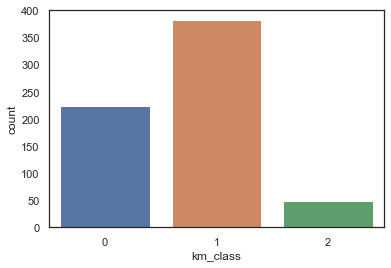

In [26]:
sns.countplot(x=cccd_s['km_class']);

And a look at our data again after clustering predictions have been applied:

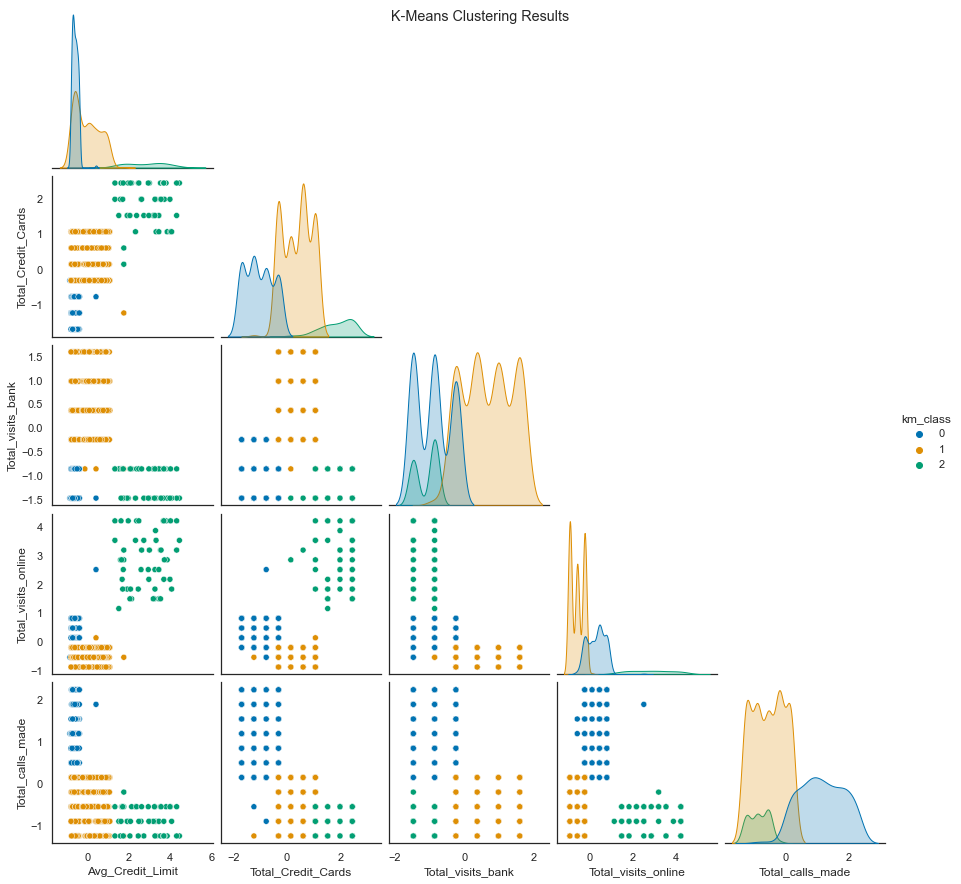

In [27]:
g = sns.pairplot(cccd_s, kind='scatter', hue='km_class', palette='colorblind', corner=True);
g.fig.suptitle("K-Means Clustering Results");

## Heirarchical Clustering

In [28]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import pdist

Cophenetic Correlation for Various Methods

In [29]:
methods = {'ward':None, 'complete':None, 'average':None, 'single':None}
max_cophs = {'ward':None, 'complete':None, 'average':None, 'single':None}

In [30]:
corr_results = {}

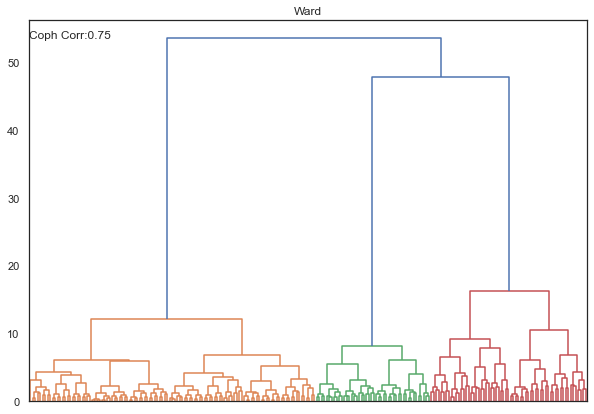

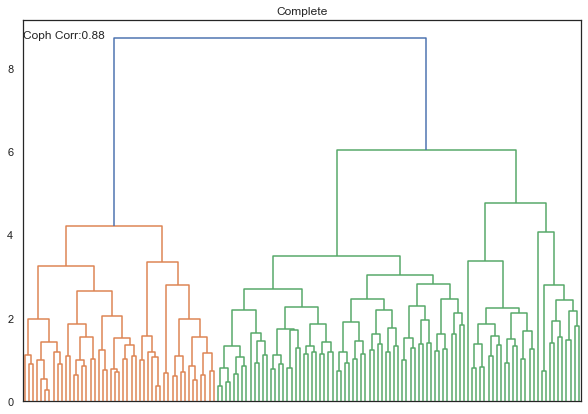

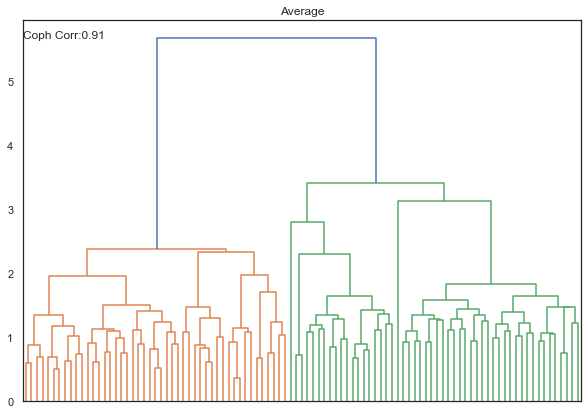

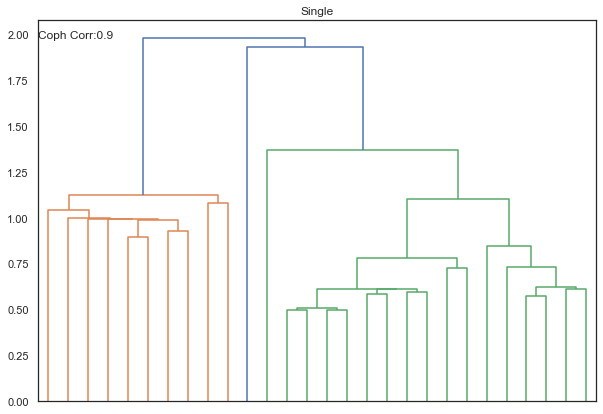

In [31]:
for method in methods:
    
    plt.figure(figsize=(10, 7))
    link = shc.linkage(cccd_s, method)
    dend = shc.dendrogram(link, no_labels=True, truncate_mode='level', p=7, distance_sort='descending', show_leaf_counts=True)
    
    orig_dists = pdist(cccd_s)
    coph_dists = shc.cophenet(link)
    coph_corr = round(np.corrcoef(orig_dists, coph_dists)[0,1], 2)
    coph_max = np.max(coph_dists)
    
    corr_results[method] = coph_corr
    
    plt.title(method.capitalize())
    plt.annotate(f'Coph Corr:{coph_corr}', xy=(0, coph_max), )
       
    plt.show()

The Complete method seems to be doing the best job at cleanly clustering observations despite having a lower correlation than the Average method.  The Average method is the only dendrogram suggesting 2 clusters and, visually at least, appears to be intermixing two clusters.

In [32]:
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')
cccd_s[f'h_complete'] = ac.fit_predict(cccd_s)

In [33]:
cccd_s.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,km_class,h_complete
0,1.767076,-1.241704,-0.858568,-0.546642,-1.257006,1,0
1,0.423440,-0.780379,-1.471163,2.516526,1.884177,0,0
2,0.423440,1.064922,-0.858568,0.134062,0.139075,1,2
3,-0.114014,0.142271,-0.858568,-0.546642,0.139075,1,2
4,1.767076,0.603597,-1.471163,3.197230,-0.209945,2,1


Counts of each cluster

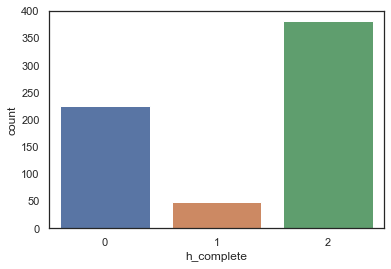

In [34]:
sns.countplot(x=cccd_s['h_complete']);

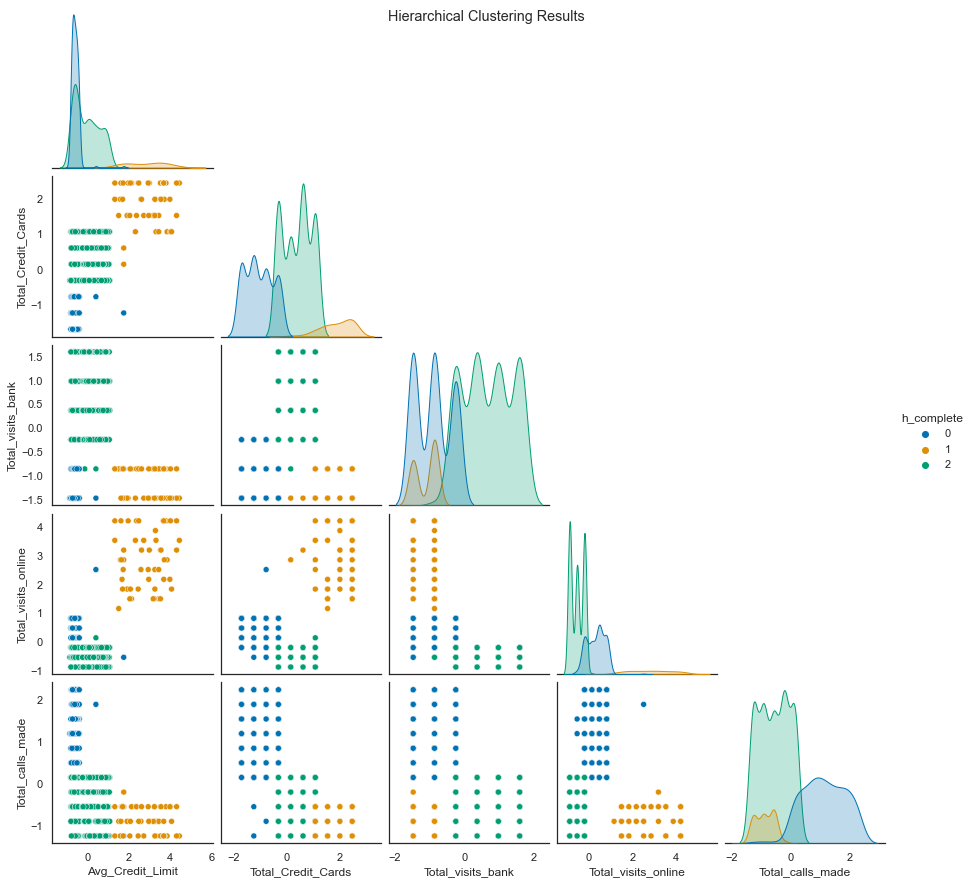

In [35]:
g = sns.pairplot(data=cccd_s, vars=['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'], hue='h_complete', palette='colorblind', corner=True);
g.fig.suptitle("Hierarchical Clustering Results");

## Cluster Comparison and Profiling

Average values for each class, by clustering algo:

In [36]:
cccd_s.drop(['h_complete'], axis=1).groupby('km_class').mean().T

km_class,0,1,2
Avg_Credit_Limit,-0.593044,-0.017146,2.844727
Total_Credit_Cards,-1.052232,0.375349,1.884010
Total_visits_bank,-0.899590,0.669712,-1.108607
Total_visits_online,0.322471,-0.554660,2.849932
Total_calls_made,1.140951,-0.557138,-0.872371


In [37]:
cccd_s.drop(['km_class'], axis=1).groupby('h_complete').mean().T

h_complete,0,1,2
Avg_Credit_Limit,-0.582555,2.844727,-0.021829
Total_Credit_Cards,-1.053074,1.884010,0.379593
Total_visits_bank,-0.899408,-1.108607,0.673723
Total_visits_online,0.318609,2.849932,-0.554682
Total_calls_made,1.130293,-0.872371,-0.555301


Median values for each class, by clustering algo:

In [38]:
cccd_s.drop(['h_complete'], axis=1).groupby('km_class').median().T

km_class,0,1,2
Avg_Credit_Limit,-0.597723,-0.087141,2.976349
Total_Credit_Cards,-1.241704,0.603597,1.987572
Total_visits_bank,-0.858568,0.366622,-0.858568
Total_visits_online,0.474414,-0.546642,2.856878
Total_calls_made,1.186136,-0.558965,-0.907986


In [39]:
cccd_s.drop(['km_class'], axis=1).groupby('h_complete').median().T

h_complete,0,1,2
Avg_Credit_Limit,-0.597723,2.976349,-0.087141
Total_Credit_Cards,-1.241704,1.987572,0.603597
Total_visits_bank,-0.858568,-0.858568,0.366622
Total_visits_online,0.474414,2.856878,-0.546642
Total_calls_made,1.186136,-0.907986,-0.558965


Looking at the averages between the two clusterings, you can see that they are coming to almost the same conclusions, just giving them a different label. KMeans class 0 is Hierarchical's class 1. Its class 1 is Hierarchical's class 2, etc.

The following box and whisker plots provide cluster profiling and comparison by giving us the percentiles and means of each variable.

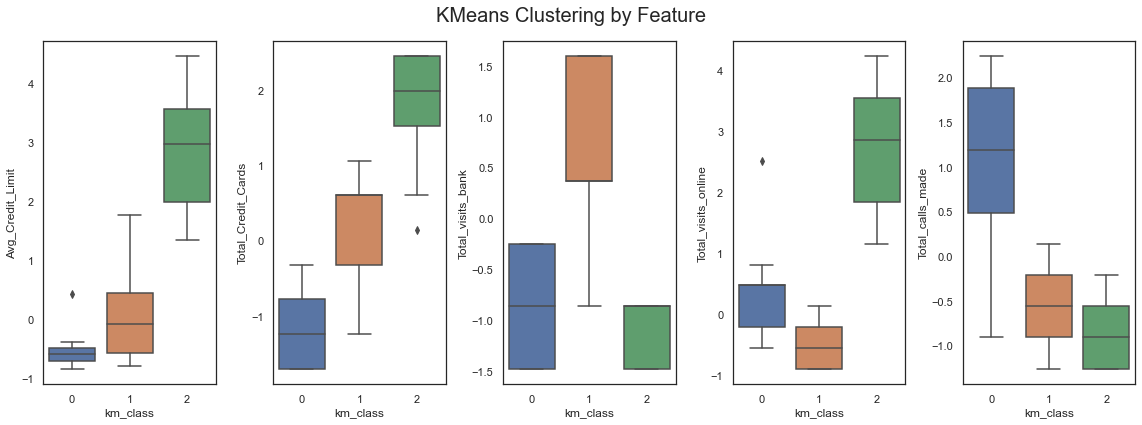

In [40]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("KMeans Clustering by Feature", fontsize=20)

for col in range(5):
    sns.boxplot(ax=axes[col],
        y=cccd_s.iloc[:, col],
        x=cccd_s['km_class'])
    
fig.tight_layout(pad=1.0)

### Insights using the KMeans Cluster Graph

- Cluster 0: Lower credit limits and card count, prefer to call the bank.
- Cluster 1: Medium credit limit and card count, tend to visit the bank.
- Cluster 2: High credit limit and card count, tend to prefer online interaction.

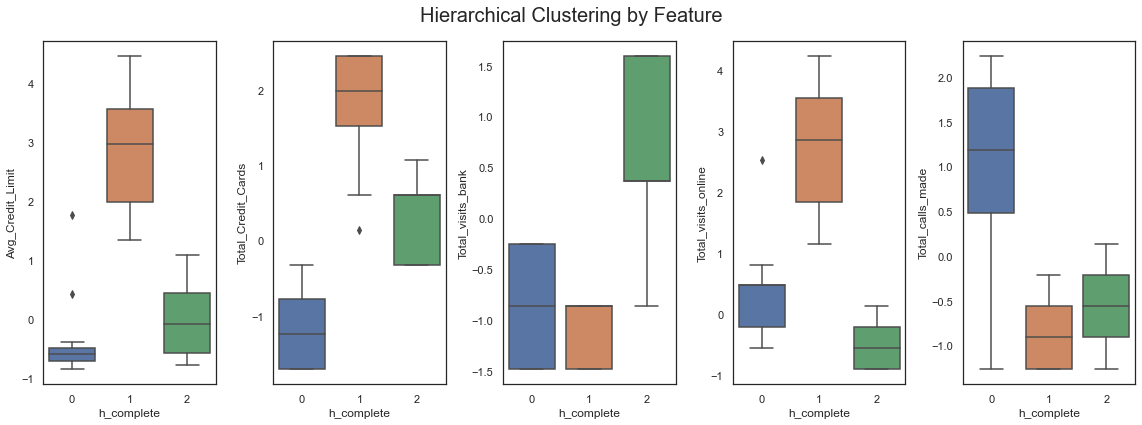

In [41]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Hierarchical Clustering by Feature", fontsize=20)

for col in range(5):
    sns.boxplot(ax=axes[col],
        y=cccd_s.iloc[:, col],
        x=cccd_s['h_complete'])
    
fig.tight_layout(pad=1.0)

### Insights using the Hierarchical Cluster Graph

- Cluster 0: Lower credit limits and card count, prefer to use the phone.
- Cluster 1: High credit limit and card count, tend to prefer online interaction.
- Cluster 2: Medium credit limit and card count, tend to like visiting the bank.

## Using PCA to Visualize Differences in Clustering Approaches

Note that we could have applied PCA to the original dataset before clustering, but that is typically done in datasets with numerous features to reduce complexity. 

This dataset only had 5 features, so I didn't want to make the interpretability tradeoff of using PCA with so few features. It can however, help us visualize the performance of the clustering algorithms after the fact!

In [42]:
pca_data = cccd_s.drop(['h_complete', 'km_class'], axis=1)

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(cccd_s)

Convert to a DataFrame for ease-of-use

In [44]:
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2']);

Add class labels from our two chosen methods of clustering:

In [45]:
pca_df['h_complete'] = cccd_s['h_complete']
pca_df['km_class'] = cccd_s['km_class']

Now we have the cluster predictions for each observation side-by-side with the Principal Components for graphing

Show the variance explain by Principal Components 1 and 2:

array([0.51411307, 0.33058906])

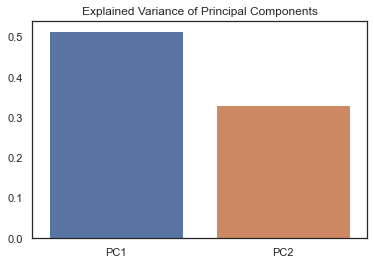

In [46]:
pc_var = pca.explained_variance_ratio_
sns.barplot(x=['PC1', 'PC2'], y=pc_var);
plt.title('Explained Variance of Principal Components');
pc_var

So we're explaining about 84% of the variance in the dataset with 2 principal components.

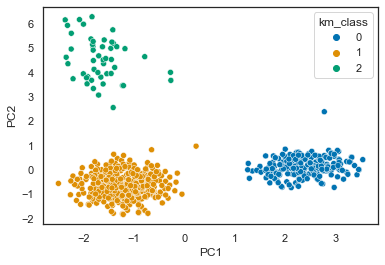

In [47]:
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='km_class', palette='colorblind');

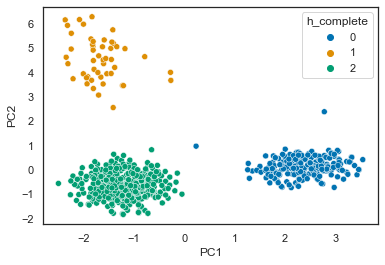

In [48]:
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='h_complete', palette='colorblind');

## Insights

- It looks like both methods did a good job (and almost exactly similar job) of clustering the customer data out, even if they applied a different ordering to the labels. This is likely due to the bottom-up approach of the Hierarchical model
- The Hierarchical Clustering grabbed an outlier that should have been classified as a 2 instead of a 0, but that appears to be the only wildling and could arguably be rejected as as outlier 
- It does seem to confirm that the data is naturally broken into 3 clusters as the other 2 analyses indicated

# Conclusion

My recommendation is based on the knowledge that you now have 3 known customer segments thanks to unsupervised learning approaches.

Using the Hierarchical class labels as my reference, the company should focus it's efforts and communications via different channels based on a customer's credit score and credit card count.
- Cluster 0 makes itself clear as the cluster with lowest credit limits and credit cards owned. These customers tend to use the phone to interact with the bank.
- Cluster 1 has the highest Average Credit Limit and Total Credit Cards, and heavily prefers Online Visits. These customers should be marketed to online rather than through other methods.
- Cluster 2 prefers visiting the bank over other interaction methods, and they tend to have lower credit limits than Cluster 1 but higher than Cluster 0. Same goes for amount of credit cards.

The bank should use the appropriate method of communication for targeted marketing campaigns, new product offers, and basic interaction. Customers will be more responsive and more likely to be reached by each effort than before. Adding data such as age, profession, etc., to the analysis will help further understand the difference in customer clusters. I have a strong feeling that age is driving the communication preferences and tolerances for risk.